# Predicting Pokemon Types from Images and Statistics

Scott Ratchford, (c) 2025

See `LICENSE.txt` for license information.

In [1]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

DATA_PATH = os.path.join(os.getcwd(), "data")
IGNORED_PKMN_PATH = os.path.join(DATA_PATH, "ignored_pokemon.csv")

CWD = os.getcwd()

# Set Pokemon image input and output paths
DATASET_DIR = os.path.join(DATA_PATH, "pokemon_images", "dataset")
TRAIN_IMG_DIR = os.path.join(DATA_PATH, "pokemon_images", "train_images")
TEST_IMG_DIR = os.path.join(DATA_PATH, "pokemon_images", "test_images")

# Set Pokemon color output path
ALL_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors.csv")
TRAIN_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors_train.csv")
TEST_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors_test.csv")

# Set Pokemon statistics input path
PKMN_STATS_PATH = os.path.join(DATA_PATH, "pokemon_stats.csv")
TRAIN_PKMN_STATS_PATH = os.path.join(DATA_PATH, "pokemon_stats_train.csv")
TEST_PKMN_STATS_PATH = os.path.join(DATA_PATH, "pokemon_stats_test.csv")

RNG_SEED = 151

TEST_SIZE = 0.2

In [2]:
# Import in-game statistics dataset
pkmn_stats = pd.read_csv(PKMN_STATS_PATH, encoding="utf-8")
print(f"PKMN: {pkmn_stats.shape[0]}")
print(f"PKMN Stats: {list(pkmn_stats.columns)}")

# Drop rows that contain Pokemon to be ignored
ignored_pkmn = pd.read_csv(IGNORED_PKMN_PATH, encoding="utf-8", delimiter="\t")
ignored_pkmn = ignored_pkmn.dropna(axis=0, subset=["Number"])
print(f"Ignored PKMN: {ignored_pkmn["Name"].tolist()}")

pkmn_stats = pkmn_stats[~pkmn_stats["Number"].isin(ignored_pkmn["Number"])]
print(f"PKMN after dropping ignored: {pkmn_stats.shape[0]}")


PKMN: 1023
PKMN Stats: ['Number', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']
Ignored PKMN: ['Giratina', 'Darmanitan', 'Hoopa']
PKMN after dropping ignored: 1022


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = pkmn_stats.copy()

# Drop columns that provide too much information about the Pokemon
tmi_cols = ["Name", "Generation"]
X = X.drop(labels=tmi_cols, axis=1)

# Drop other columns
drop_cols = ["Type 2", ]
X = X.drop(labels=drop_cols, axis=1)

# Drop columns containing target information
target_cols = ["Type 1", ]
y = pkmn_stats[target_cols].copy()
X = X.drop(labels=target_cols, axis=1)

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
y["Type 1"] = type_label_encoder.fit_transform(y["Type 1"])
y["Type 1"] = y["Type 1"].astype(dtype=int)
# y_train["Type 2"] = type_label_encoder.fit_transform(y_train["Type 2"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RNG_SEED)

In [4]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_stats_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 11),
    "leaf_size": range(10, 41),
    "p": range(1, 4),
    "weights": ("distance", "uniform", ),
    "algorithm": ("kd_tree", "ball_tree", ),
}

knn_clf = GridSearchCV(knn_stats_model, knn_hyperparameters, n_jobs=-1)

knn_stats_model = knn_clf.fit(X_train, y_train.values.ravel())

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix

knn_pred = knn_clf.predict(X_test)

accuracy = accuracy_score(y_test, knn_pred)
conf_matrix = confusion_matrix(y_test, knn_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.09268292682926829, Test Error: 0.9073170731707317
Confusion Matrix:
[[5 2 0 0 0 0 2 0 0 2 0 0 3 3 0 0 2 3]
 [0 0 0 1 0 2 1 0 0 0 1 0 1 0 0 0 0 1]
 [1 1 1 0 1 0 1 0 0 2 0 0 0 1 0 0 1 2]
 [2 1 0 0 0 3 2 1 0 1 0 0 1 0 0 0 0 4]
 [0 0 0 0 1 0 1 0 1 3 0 0 3 0 1 0 1 1]
 [1 0 0 0 1 0 0 0 0 1 1 0 3 1 0 0 0 0]
 [0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 3]
 [0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 1 2]
 [1 1 1 0 0 0 3 0 0 1 2 0 1 0 1 1 0 7]
 [2 0 0 0 0 2 0 0 0 1 1 1 1 0 0 1 1 0]
 [1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
 [3 3 1 0 0 0 0 0 0 4 2 0 2 3 0 0 0 2]
 [1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 2]
 [0 2 1 1 0 0 1 0 2 2 0 1 1 0 3 1 0 1]
 [0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1]
 [0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 2 0]
 [0 0 0 0 1 0 1 1 0 3 0 0 1 2 2 2 1 1]]


In [6]:
# Match test data with original data to find names and types
pkmn_stats.reset_index()
knn_pred_df = pd.DataFrame(knn_pred, columns=["Type 1 Prediction"])
knn_pred_df["Type 1 Prediction"] = type_label_encoder.inverse_transform(knn_pred_df["Type 1 Prediction"])
knn_pred_df.reset_index()

# join knn pred with X_test on index
x_test_and_knn_pred = pd.merge(X_test, knn_pred_df, how="inner", left_index=True, right_index=True, validate="1:1")
# join that result to pkmn_stats to find predicted type
join_on = ["Number", "Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Legendary"]
rejoined_data = pd.merge(pkmn_stats, x_test_and_knn_pred, how="inner", left_on=join_on, right_on=join_on, validate="1:1")

## Images

In [7]:
import os

CWD = os.getcwd()

# Set Pokemon image input and output paths
DATASET_DIR = os.path.join(CWD, "data", "pokemon_images", "dataset")
TRAIN_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "train_images")
TEST_IMG_DIR = os.path.join(CWD, "data", "pokemon_images", "test_images")

# Set Pokemon color output path
ALL_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors.csv")
TRAIN_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors_train.csv")
TEST_PKMN_COLORS_PATH = os.path.join(CWD, "pokemon_colors_test.csv")

### Add Pokemon Numbers to Color Data

In [6]:
# Import in-game statistics dataset
pkmn_numbers = pd.read_csv(PKMN_STATS_PATH, encoding="utf-8")

# # Drop rows that contain Pokemon to be ignored
# ignored_pkmn = pd.read_csv(IGNORED_PKMN_PATH, encoding="utf-8", delimiter="\t")
# ignored_pkmn = ignored_pkmn.dropna(axis=0, subset=["Number"])
# pkmn_numbers = pkmn_numbers[~pkmn_numbers["Number"].isin(ignored_pkmn["Number"])]

# Drop all columns except Name and Number
pkmn_numbers = pkmn_numbers.drop(labels=['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'], axis=1)
pkmn_numbers["Name"] = pkmn_numbers["Name"].apply(lambda x: x.lower())  # for compatibility with image dataset

print(f"Imported names and numbers for {pkmn_numbers.shape[0]} Pokemon.")

Imported names and numbers for 1023 Pokemon.


### Load Pokemon Color Data from Files

In [7]:
pkmn_color_train_df = pd.read_csv(TRAIN_PKMN_COLORS_PATH, sep=",", encoding="utf-8", index_col=0)
pkmn_color_test_df = pd.read_csv(TEST_PKMN_COLORS_PATH, sep=",", encoding="utf-8", index_col=0)

pkmn_color_test_df = pd.merge(pkmn_numbers, pkmn_color_test_df, how="inner", left_on=["Name", ], right_on=["Name", ])
# pkmn_color_test_df = pkmn_color_test_df.dropna()
unique_names_test = pkmn_color_test_df["Name"].unique().shape[0]
print(f"Data for {unique_names_test} testing Pokemon loaded.")

pkmn_color_train_df = pd.merge(pkmn_numbers, pkmn_color_train_df, how="inner", left_on=["Name", ], right_on=["Name", ])
# pkmn_color_train_df = pkmn_color_train_df.dropna()
unique_names_train = pkmn_color_train_df["Name"].unique().shape[0]
print(f"Data for {unique_names_train} training Pokemon loaded.")

Data for 190 testing Pokemon loaded.
Data for 739 training Pokemon loaded.


In [8]:
def sample_min_entries(df: pd.DataFrame, target_col: str, min_entries: int, random_state=42):
    """
    Returns a new DataFrame containing a random subset such that
    each unique value in target_col is represented with at least min_entries entries,
    or all entries if there are less than min_entries available.
    
    Parameters:
    - df: Original DataFrame.
    - min_entries: Minimum number of entries to sample from each group.
    - random_state: Seed for reproducibility.
    """
    # Group by target_col and sample n=min(len(group), min_entries) rows from each group.
    return df.groupby(target_col, group_keys=False).apply(
        lambda group: group.sample(n=min(len(group), min_entries), random_state=random_state), include_groups=True
    )

In [20]:
# Adjust data to provide equivalent amounts for each type
types_train = {color: pkmn_color_train_df[pkmn_color_train_df["Type 1"] == color].shape[0] for color in pkmn_color_train_df["Type 1"].unique()}
least_train = min(types_train.values())
most_train = max(types_train.values())
pkmn_color_train_df_edited = sample_min_entries(pkmn_color_train_df, "Type 1", most_train)    # least_train

types_test = {color: pkmn_color_test_df[pkmn_color_test_df["Type 1"] == color].shape[0] for color in pkmn_color_test_df["Type 1"].unique()}
least_test = min(types_test.values())
most_test = max(types_test.values())
pkmn_color_test_df_edited = sample_min_entries(pkmn_color_test_df, "Type 1", most_test)   # least_test

C:\Users\Scott\AppData\Local\Temp\ipykernel_27120\251377683.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(
C:\Users\Scott\AppData\Local\Temp\ipykernel_27120\251377683.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(


In [21]:
from sklearn.preprocessing import LabelEncoder


drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "filename", ])
# Drop other columns
drop_color_cols.extend(["Type 2", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", ])

X_colors_train = pkmn_color_train_df_edited.drop(labels=drop_color_cols, axis=1)
X_colors_test = pkmn_color_test_df_edited.drop(labels=drop_color_cols, axis=1)
y_colors_train = pkmn_color_train_df_edited[["Type 1"]].copy()
y_colors_test = pkmn_color_test_df_edited[["Type 1"]].copy()

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
y_colors_train["Type 1"] = type_label_encoder.fit_transform(y_colors_train["Type 1"])
y_colors_test["Type 1"] = type_label_encoder.fit_transform(y_colors_test["Type 1"])
y_colors_train["Type 1"] = y_colors_train["Type 1"].astype(dtype=int)
y_colors_test["Type 1"] = y_colors_test["Type 1"].astype(dtype=int)

### Pokemon Colors KNN

In [44]:
# Create the KNN model for colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_colors_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(15, 31),
    "leaf_size": range(10, 31),
    "p": range(1, 4),
    "weights": ("distance", ),  # "uniform", 
    "algorithm": ("kd_tree", ), # "ball_tree", 
    "metric": ("minkowski", "chebyshev", ),
}

knn_colors_clf = GridSearchCV(knn_colors_model, knn_hyperparameters, n_jobs=-1)
knn_colors_model = knn_colors_clf.fit(X_colors_train, y_colors_train.values.ravel())

print(knn_colors_clf.best_params_)

{'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}


In [45]:
# import pickle

# # Save model to file
# with open(os.path.join(CWD, "models", "knn_colors_clf.pickle"), "wb") as f:
#     pickle.dump(knn_colors_clf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
from sklearn.metrics import accuracy_score

knn_color_pred = knn_colors_clf.predict(X_colors_test)

accuracy = accuracy_score(y_colors_test, knn_color_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"{accuracy * y_colors_test.shape[0]:.0f} out of {y_colors_test.shape[0]} correctly predicted")

Accuracy: 0.15304948216340622, Test Error: 0.8469505178365938
266 out of 1738 correctly predicted


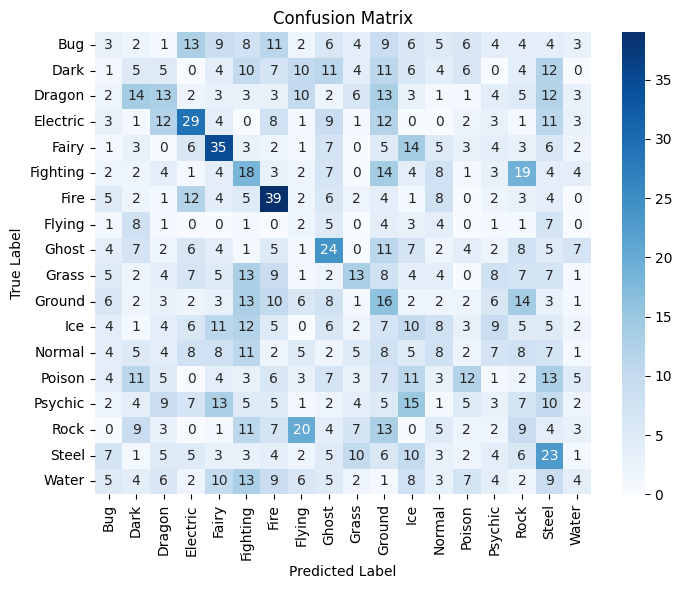

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

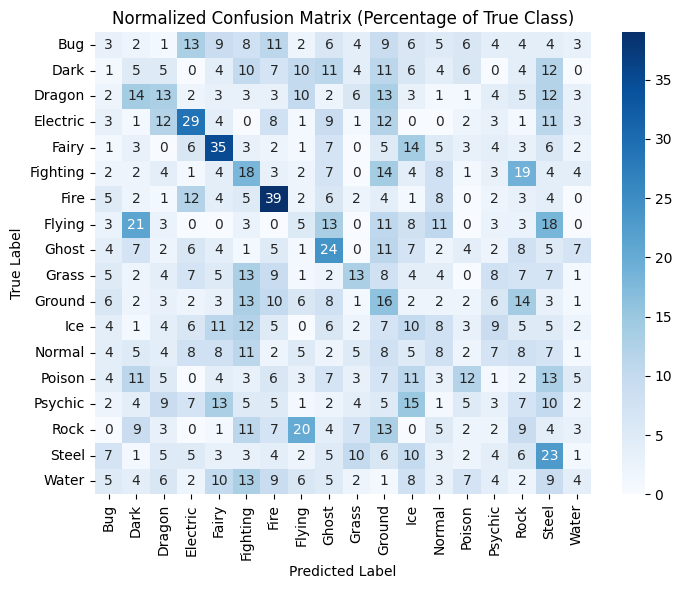

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentage of True Class)')
plt.show()

### Pokemon Colors RF

In [22]:
# Create the KNN model for colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_colors_model = RandomForestClassifier()
# hyperparameters to try
rf_hyperparameters = {
    "n_estimators": range(200, 550, 50),
    "min_samples_split": (10, ),
    "random_state": (RNG_SEED, ),
}

rf_colors_clf = GridSearchCV(rf_colors_model, rf_hyperparameters, n_jobs=-1)
rf_colors_model = rf_colors_clf.fit(X_colors_train, y_colors_train.values.ravel())

print(rf_colors_clf.best_params_)

{'min_samples_split': 10, 'n_estimators': 250, 'random_state': 151}


In [23]:
# import pickle

# # Save model to file
# with open(os.path.join(CWD, "models", "rf_colors_clf.pickle"), "wb") as f:
#     pickle.dump(rf_colors_clf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
from sklearn.metrics import accuracy_score

rf_color_pred = rf_colors_clf.predict(X_colors_test)

accuracy = accuracy_score(y_colors_test, rf_color_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"{accuracy * y_colors_test.shape[0]:.0f} out of {y_colors_test.shape[0]} correctly predicted")

Accuracy: 0.28624192059095105, Test Error: 0.713758079409049
1550 out of 5415 correctly predicted


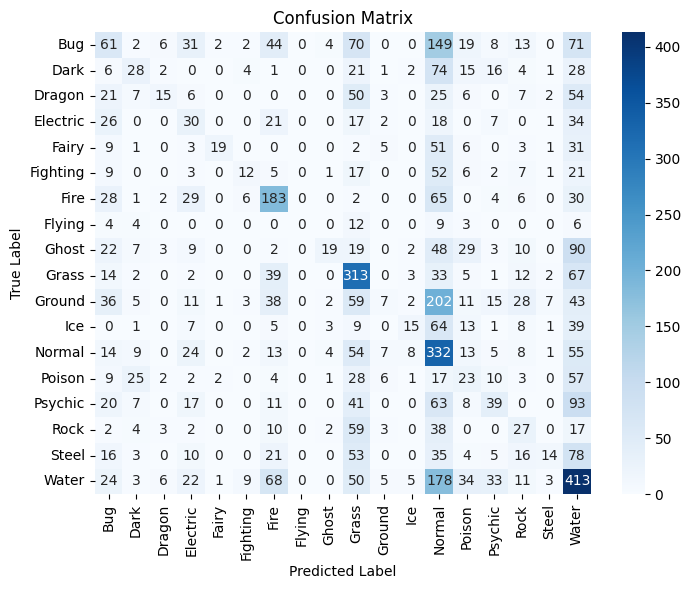

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, rf_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

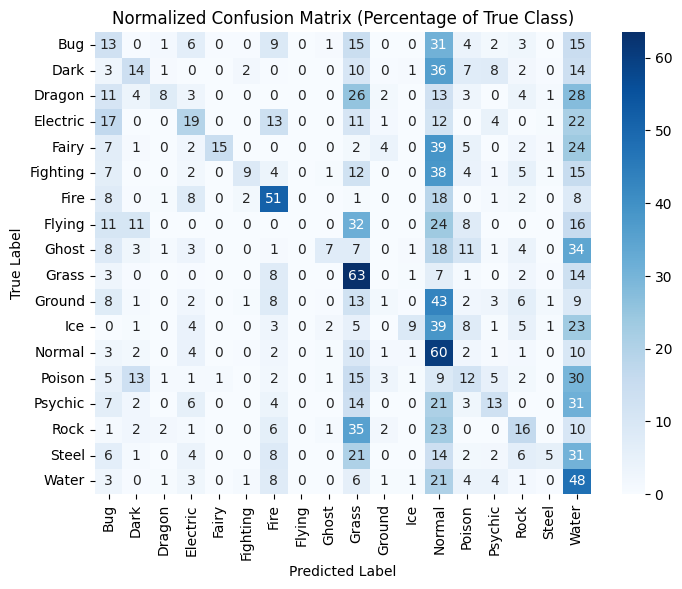

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, rf_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentage of True Class)')
plt.show()

In [ ]:
# Look at specific cases
charizards = pkmn_color_test_df[pkmn_color_test_df["Name"] == "charizard"]

# Find Charizards with incorrect predictions
